In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [29]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u

import corner

from importlib import reload

import h5py

from scipy.interpolate import interp1d

import seaborn as sns

import rewtlisamples

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

This is just a function that draws from the LI prior for $M_\mathrm{min} \leq m_2 < m_1 < M_\mathrm{max}$ and $d_L < d_{L,\mathrm{max}}$.

In [52]:
def draw_m1m2dlt_liprior(mmin, mmax, dlmax, dt, size):
    mas = mmin + (mmax-mmin)*rand(size)
    mbs = mmin + (mmax-mmin)*rand(size)
    
    m1s = where(mas > mbs, mas, mbs)
    m2s = where(mas > mbs, mbs, mas)
    
    dl3 = dlmax**3*rand(size)
    dl = cbrt(dl3)
        
    return (m1s, m2s, dl)

In [53]:
samples = column_stack(draw_m1m2dlt_liprior(1, 100, Planck15.luminosity_distance(1).to(u.Gpc).value, 1, 1000000))

The samples look like they correspond to the prior (flat in detector frame, $d_L^2$).

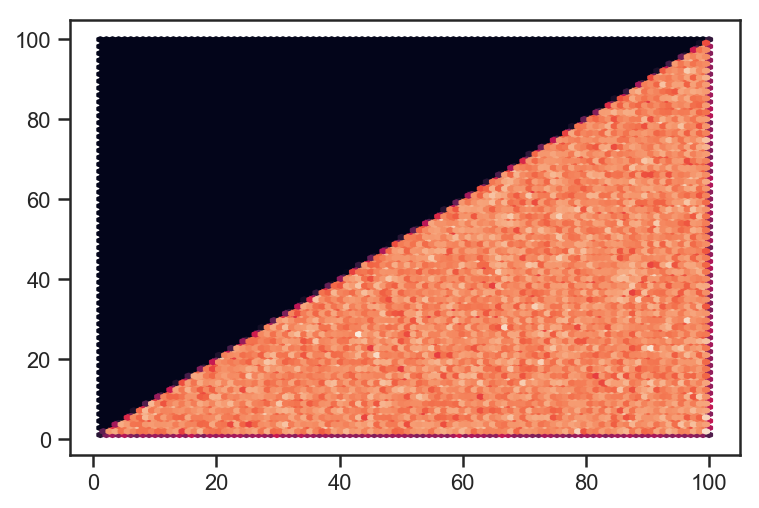

In [54]:
hexbin(samples[:,0], samples[:,1])

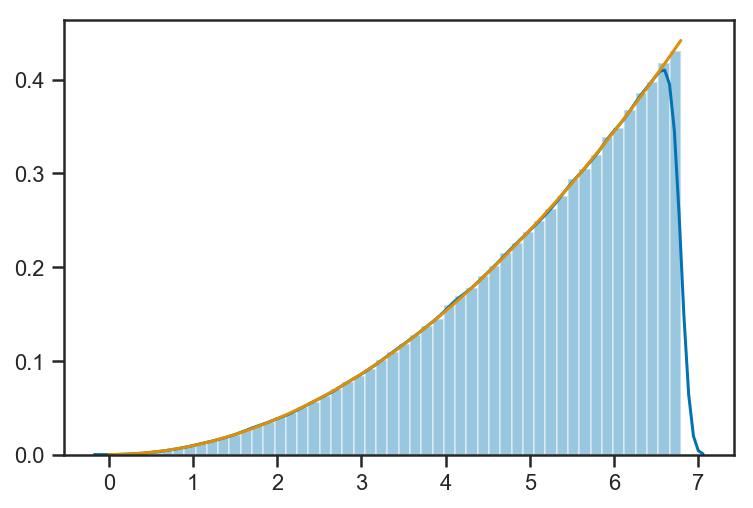

In [55]:
sns.distplot(samples[:,2])
xs = linspace(0, Planck15.luminosity_distance(1).to(u.Gpc).value, 1000)
plot(xs, 3.0*xs*xs/(Planck15.luminosity_distance(1).to(u.Gpc).value**3))

Now we re-weight according to the library.  This will produce samples that are flat in $m_1$-$m_2$ (source frame), and also flat in comoving volume.  

In [56]:
logwts = rewtlisamples.log_lirewt_factor(samples[:,2], distance_unit=u.Gpc)

In [57]:
logwts = logwts - np.max(logwts) # Normalize to maxwt = 1

In [58]:
logrs = log(random.uniform(low=0, high=1, size=logwts.shape))

In [59]:
sel = logrs < logwts

In [60]:
rewt_samples = samples[sel,:]

This check is a bit subtle.  First, we have to avoid the edges of the $m_1$-$m_2$ plane, because the redshifting introduces a distance-dependent cutoff in mass.  See `cut` below.

Second, we are checking that after cutting we have 

* Flat in $m_1$-$m_2$ (2D).  Which implies 
* A ramp upward in marginal $m_1$ and
* A ramp downward in marginal $m_2$.
* $\frac{1}{1+z}$ in $p(V)$.

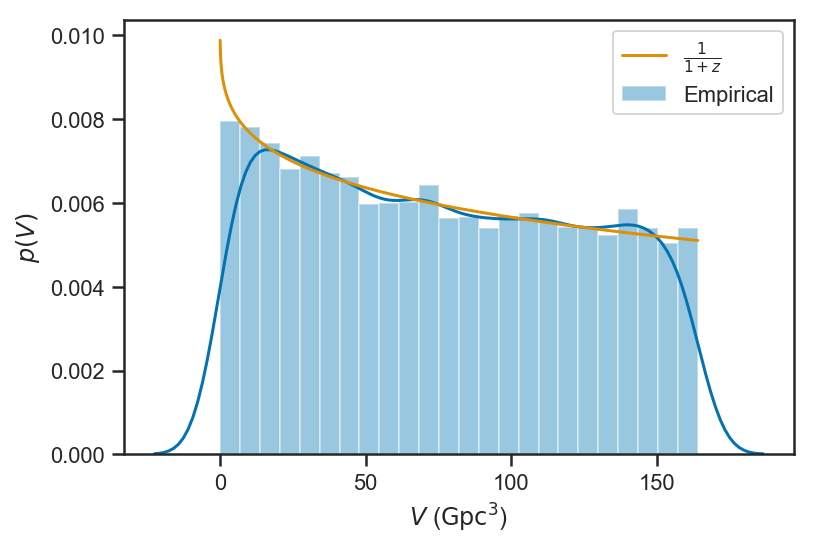

<Figure size 432x288 with 0 Axes>

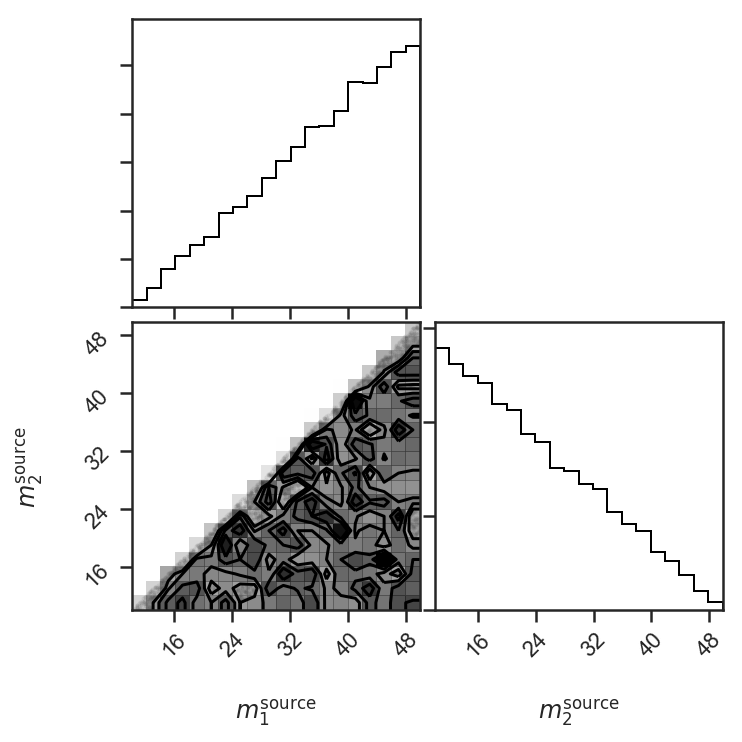

In [79]:
d = rewt_samples[:,2]
zi = linspace(0, 3, 1000)
di = Planck15.luminosity_distance(zi).to(u.Gpc).value
z = interp1d(di, zi)(d)

V = Planck15.comoving_volume(z).to(u.Gpc**3).value
m1 = rewt_samples[:,0]/(1+z)
m2 = rewt_samples[:,1]/(1+z)

cut = (m2 > 10) & (m1 < 50)

sns.distplot(V[cut], label='Empirical')

s = argsort(V[cut])

plot(V[cut][s], 1/(1+z[cut][s])/trapz(1/(1+z[cut][s]), V[cut][s]), label=r'$\frac{1}{1+z}$')
xlabel(r'$V$ ($\mathrm{Gpc}^3$)')
ylabel(r'$p(V)$')
legend(loc='best')

figure()
corner.corner(column_stack((m1[cut], m2[cut])),
              labels=[r'$m_1^{\mathrm{source}}$', r'$m_2^{\mathrm{source}}$']);